# Classification Practice with MNIST Dataset

import mnist dataset from sklearn

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


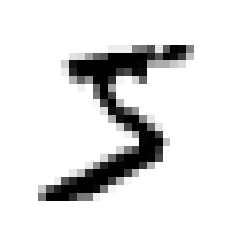

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28) # each image is 28x28 pixels large

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

Note the label is a string.  The ML algorithms will expect numbers so cast y as int

In [7]:
import numpy as np

y = y.astype(np.uint8)

Split the image dataset into train/test (MNIST is already organizes the first 60k images for training and the last 10k for test.  Also note that it's already shuffled.) 

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## BINARY CLASSIFIERS

## Train a SGD binary classifier

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, false otherwise
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

In [11]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

The classifier properly identified the test digit above as a 5.

## Measuring Accuracy Using Cross-Validation

This is a manual implementation of Cross-Validation and is roughly the same as sklearn.cross_val_score()


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [14]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[train_index]
    y_test_fold = y_train_5[train_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/home/jordan/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.951675
0.96725
0.965325


Compare the implementation with sklearn's cross_val_score

In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # accuracy is not a good measure

array([0.95035, 0.96035, 0.9604 ])

## Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Summarize confusion matrix with precision, recall, and f1_score

* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)
* f1_score = 2 * (precision * recall) / (precision + recall)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred)) # aka sensitivity, true positive rate
print(f1_score(y_train_5, y_train_pred)) # favors classifiers with similar precision and recall

0.8370879772350012
0.6511713705958311
0.7325171197343846


## ROC Curve

Receiver operating characteristic (ROC) curve is another common tool used with binary classifiers
Plots the True Positive Rate (recall) vs false positive rate --> Plots sensitivity (recall)

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

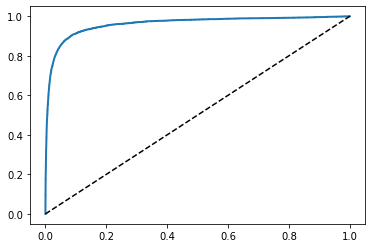

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--") # dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

ROC AUC

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Train Random Forest Classifier

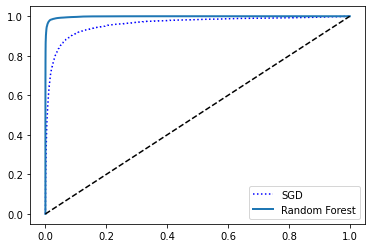

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [36]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

y_scores_forest_int = []
for i in y_scores_forest: 
    if i > 0.5: 
        y_scores_forest_int.append(1)
    else:
        y_scores_forest_int.append(0)

precision_score(y_train_5, y_scores_forest_int)

0.9905083315756169

In [37]:
recall_score(y_train_5, y_scores_forest_int)

0.8662608374838591

## MULTICLASS CLASSIFIERS

One vs One classifers 
* Train a binary classifier for every combination of classes (1 vs 2, 2 vs 3, 1 vs 3, etc)
* Usually doesn't scale well, but can be good for training parts of a classifier on smaller datasets rather than the entire set.

One vs the Rest classifiers
* Gives the item a multiple scores for each item and the item is classified as the highest scoring category.